# CIFAR-10 classification
## 1. Baseline
### 1.1.  import libraries and define hyperparameters

In [ ]:
!pip -q install cleverhans
!pip -q install einops
!pip -q install ptflops

     |████████████████████████████████| 327kB 7.8MB/s 
     |████████████████████████████████| 163kB 26.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 


In [ ]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt 
import numpy as np
import os 
from ptflops import get_model_complexity_info
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import nn, einsum
from torchvision.models import resnet34, resnet101, mobilenet_v2
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [ ]:
device = 'cuda'

### 1.2. load and normalize CIFAR-10

In [ ]:
batch_size = 256

In [ ]:
mean = [0.5, 0.5, 0.5]
std =  [0.5, 0.5, 0.5]
transform_train = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1.3. define a transformer

In [ ]:
class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 32, 32)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 8, 8)
        return out

In [ ]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
class HybridViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super(HybridViT,self).__init__()
        self.ResNetFeatures = ResNetFeatures()
        self.image_size = image_size // 4
        self.patch_size = self.image_size // (image_size//patch_size)
        self.channels = 64
        self.ViT = ViT(image_size=self.image_size,
            patch_size=self.patch_size, 
            num_classes=num_classes, 
            dim=dim, 
            depth=depth, 
            heads=heads, 
            mlp_dim=mlp_dim,
            pool='cls',
            channels=self.channels, 
            dim_head=64,
            dropout=0.,
            emb_dropout = 0.)
        
    def forward(self, img):
        x = self.ResNetFeatures(img)
        x = self.ViT(x)
        return x

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

class FeedForward_v2(nn.Module):
    def __init__(self):
        super().__init__()
        inplanes=planes=1
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)

    def forward(self, x):
        x = torch.unsqueeze(x,1)
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        out = torch.squeeze(x,1)
        return out

class Transformer_v2(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward_v2())
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT_v2(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer_v2(dim, depth, heads, dim_head, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

class HybridViT_v2(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        self.ResNetFeatures = ResNetFeatures()
        self.image_size = image_size // 4
        self.patch_size = self.image_size // (image_size//patch_size)
        self.channels = 64
        self.ViT = ViT_v2(image_size=self.image_size,
            patch_size=self.patch_size, 
            num_classes=num_classes, 
            dim=dim, 
            depth=depth, 
            heads=heads, 
            mlp_dim=mlp_dim,
            pool='cls',
            channels=64, 
            dim_head=64,
            dropout=0.,
            emb_dropout = 0.)
        
    def forward(self, img):
        x = self.ResNetFeatures(img)
        x = self.ViT(x)
        return x

In [ ]:
resnet_feature = ResNetFeatures().to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


model 1: Pure ViT, add resnet_feature head.


In [ ]:
model = ViT(
    image_size=8,
    patch_size=4,
    num_classes=10,
    dim = 512,
    depth = 12,
    heads = 16,
    channels=64,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

model2: Hybrid ViT, with a trainable resnet head

In [ ]:
model = HybridViT(
    image_size=32,
    patch_size=16,
    num_classes=10,
    dim = 512,
    depth = 10,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

model 3: ViT version 2, add resnet_feature head

In [ ]:
model = ViT_v2(
    image_size=8,
    patch_size=4,
    num_classes=10,
    dim = 512,
    depth = 12,
    heads = 16,
    channels=64,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

简直逆天 还有这么拉的玩意儿

model 4: Hybrid ViT version 2, change the feedforward to be convolution 

In [ ]:
model = HybridViT_v2(
    image_size=32,
    patch_size=16,
    num_classes=10,
    dim = 512,
    depth = 10,
    heads = 16,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

Let's see the parameter numbers and FLOPs of Hybrid ViT

In [ ]:
macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.12 GMac
Number of parameters:           21.76 M 


### 1.4. Let's start our training!

In [ ]:
lr = 3e-6

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)

In [ ]:
loss_record = {'train': [], 'validation': []} 
acc_record = {'train': [], 'validation': []} 

In [ ]:
def train(epochs, model, resnet_feature, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer, scheduler=None, adv_train=False):
    #optimizer.zero_grad()
    #optimizer.step()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        print("current lr = %lf"%optimizer.param_groups[0]['lr'])

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            # with torch.no_grad():
            #     data = resnet_feature(data)
            if adv_train:
                # Replace clean example with adversarial example for adversarial training
                data = projected_gradient_descent(model, data, 0.3, 0.01, 40, np.inf)
            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # scheduler.step()
            
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
        
        # scheduler.step()

        loss_record['train'].append(epoch_loss.detach().cpu().item())
        acc_record['train'].append(epoch_accuracy.detach().cpu().item())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)
                # data = resnet_feature(data)
                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
            loss_record['validation'].append(epoch_val_loss.detach().cpu().item())
            acc_record['validation'].append(epoch_val_accuracy.detach().cpu().item())

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

In [ ]:
epochs = 20

In [ ]:
train(epochs, model, resnet_feature, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer)

current lr = 0.000003



Epoch : 1 - loss : 0.5920 - acc: 0.7931 - val_loss : 0.6987 - val_acc: 0.7576

current lr = 0.000003



Epoch : 2 - loss : 0.5787 - acc: 0.7979 - val_loss : 0.7010 - val_acc: 0.7586

current lr = 0.000003



Epoch : 3 - loss : 0.5752 - acc: 0.7970 - val_loss : 0.7076 - val_acc: 0.7499

current lr = 0.000003



Epoch : 4 - loss : 0.5701 - acc: 0.8014 - val_loss : 0.6993 - val_acc: 0.7606

current lr = 0.000003



Epoch : 5 - loss : 0.5720 - acc: 0.7991 - val_loss : 0.6897 - val_acc: 0.7571

current lr = 0.000003



Epoch : 6 - loss : 0.5625 - acc: 0.8034 - val_loss : 0.6913 - val_acc: 0.7628

current lr = 0.000003



Epoch : 7 - loss : 0.5633 - acc: 0.8032 - val_loss : 0.7080 - val_acc: 0.7573

current lr = 0.000003



Epoch : 8 - loss : 0.5673 - acc: 0.8024 - val_loss : 0.6787 - val_acc: 0.7673

current lr = 0.000003



Epoch : 9 - loss : 0.5681 - acc: 0.8011 - val_loss : 0.7078 - val_acc: 0.7489

current lr = 0.000003



Epoch : 10 - loss : 0.5598 - acc: 0.8032 - val_loss : 0.7032 - val_acc: 0.7533

current lr = 0.000003



Epoch : 11 - loss : 0.5639 - acc: 0.8020 - val_loss : 0.6915 - val_acc: 0.7565

current lr = 0.000003



Epoch : 12 - loss : 0.5558 - acc: 0.8038 - val_loss : 0.6952 - val_acc: 0.7605

current lr = 0.000003



Epoch : 13 - loss : 0.5567 - acc: 0.8051 - val_loss : 0.6885 - val_acc: 0.7626

current lr = 0.000003



Epoch : 14 - loss : 0.5553 - acc: 0.8050 - val_loss : 0.7042 - val_acc: 0.7594

current lr = 0.000003



Epoch : 15 - loss : 0.5560 - acc: 0.8056 - val_loss : 0.7001 - val_acc: 0.7525

current lr = 0.000003



Epoch : 16 - loss : 0.5581 - acc: 0.8064 - val_loss : 0.7036 - val_acc: 0.7584

current lr = 0.000003



Epoch : 17 - loss : 0.5543 - acc: 0.8059 - val_loss : 0.7031 - val_acc: 0.7579

current lr = 0.000003



Epoch : 18 - loss : 0.5539 - acc: 0.8045 - val_loss : 0.7130 - val_acc: 0.7510

current lr = 0.000003



Epoch : 19 - loss : 0.5497 - acc: 0.8073 - val_loss : 0.6955 - val_acc: 0.7526

current lr = 0.000003



Epoch : 20 - loss : 0.5581 - acc: 0.8055 - val_loss : 0.7112 - val_acc: 0.7579



In [ ]:
def plot_loss_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.4,2.1)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_acc_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.2,0.9)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Accurary curve of {}'.format(title))
    plt.legend()
    plt.show()


In [ ]:
%matplotlib inline

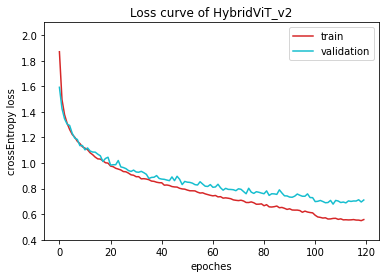

In [ ]:
plot_loss_curve(loss_record, title='HybridViT_v2')

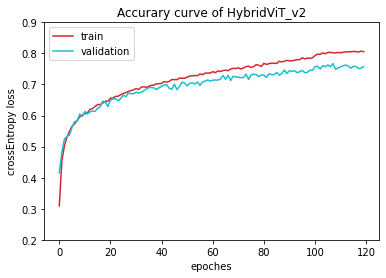

In [ ]:
plot_acc_curve(acc_record, title='HybridViT_v2')

In [ ]:
def test(model, model_name, test_loader):
    correct = 0
    correct_fgm = 0
    correct_pgd = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # images = resnet_feature(images)
        images_fgm = fast_gradient_method(model, images, 0.3, np.inf)
        images_pgd = projected_gradient_descent(model, images, 0.3, 0.01, 40, np.inf)
        # calculate outputs by running images through the network
        outputs = model(images)
        outputs_fgm = model(images_fgm)
        outputs_pgd = model(images_pgd)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        _, predicted_fgm = torch.max(outputs_fgm.data, 1)
        _, predicted_pgd = torch.max(outputs_pgd.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_fgm += (predicted_fgm == labels).sum().item()
        correct_pgd += (predicted_pgd == labels).sum().item()

    print('Accuracy of the %s on the 10000 test images: %d %%' % (model_name,
        100 * correct / total))
    print('Accuracy of the %s on the 10000 FGM adversarial images: %d %%' % (model_name,
        100 * correct / total))
    print('Accuracy of the %s on the 10000 PFD adversarial images: %d %%' % (model_name,
        100 * correct / total))

In [ ]:
test(model, 'HybridViT_v2', test_loader)

Accuracy of the HybridViT_v2 on the 10000 test images: 70 %
Accuracy of the HybridViT_v2 on the 10000 FGM adversarial images: 70 %
Accuracy of the HybridViT_v2 on the 10000 PFD adversarial images: 70 %


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/model4.pth'
torch.save(model.state_dict(), PATH)
np.save('/content/drive/MyDrive/loss_record_model4.npy',loss_record)
np.save('/content/drive/MyDrive/acc_record_model4.npy',acc_record)

In [ ]:
PATH = '/content/drive/MyDrive/model4.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
loss_record=np.load('/content/drive/MyDrive/loss_record_model4.npy',allow_pickle=True).item()
acc_record=np.load('/content/drive/MyDrive/acc_record_model4.npy',allow_pickle=True).item()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model4.pth'))


<All keys matched successfully>

In [ ]:
#model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 2. Experienment 1: resnet34

In [ ]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet40(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([5, 5, 6, 3], input_channels, classes)

In [ ]:
resnet40 = ResNet40(input_channels=3, classes=10).to(device)

In [ ]:
macs, params = get_model_complexity_info(resnet40, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.01 GMac
Number of parameters:           2.24 M  


In [ ]:
resnet40_loss_record = {'train': [], 'validation': []} 
resnet40_acc_record = {'train': [], 'validation': []} 

In [ ]:
resnet40_opt = torch.optim.Adam(mobilenet.parameters(), lr=lr)

In [ ]:
train(epochs, mobileNet, train_loader, valid_loader, resnet40_loss_record, resnet40_acc_record, criterion, resnet40_opt)

current lr = 0.000300



Epoch : 1 - loss : 2.3349 - acc: 0.1002 - val_loss : 2.3324 - val_acc: 0.0961

current lr = 0.000300



Epoch : 2 - loss : 2.3324 - acc: 0.1032 - val_loss : 2.3327 - val_acc: 0.0934

current lr = 0.000300



Epoch : 3 - loss : 2.3352 - acc: 0.0991 - val_loss : 2.3290 - val_acc: 0.0947

current lr = 0.000300



Epoch : 4 - loss : 2.3328 - acc: 0.1017 - val_loss : 2.3304 - val_acc: 0.1048

current lr = 0.000300



Epoch : 5 - loss : 2.3337 - acc: 0.1010 - val_loss : 2.3308 - val_acc: 0.1034



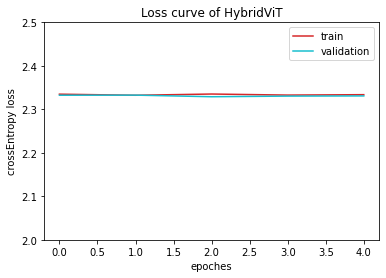

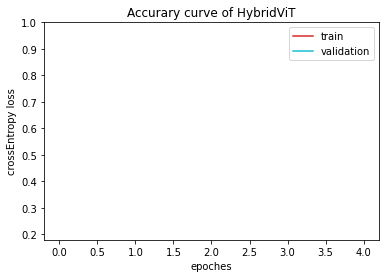

In [ ]:
plot_loss_curve(resnet40_loss_record, title='ResNet40')
plot_acc_curve(resnet40_acc_record, title='ResNet40')

In [ ]:
test(resnet40,'ResNet40', test_loader)

SyntaxError: ignored

In [ ]:
torch.save(resnet40.state_dict(), '/content/drive/MyDrive/resnet40.pth')
np.save('/content/drive/MyDrive/loss_record_resnet40.npy',resnet40_loss_record)
np.save('/content/drive/MyDrive/acc_record_resnet40.npy',resnet40_acc_record)

comparison

In [ ]:
def loss_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.ylim(0,5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

def acc_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.ylim(0,1)
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('accuracy comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

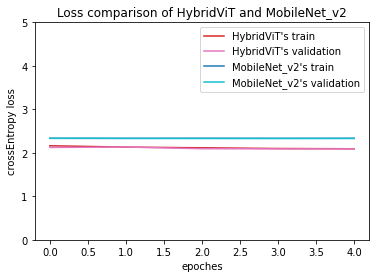

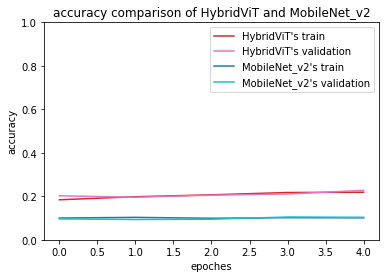

In [ ]:
loss_comparison_of_two(loss_record, resnet40_loss_record, 'HybridViT_v2', 'resnet40')
acc_comparison_of_two(acc_record, resnet40_acc_record, 'HybridViT', 'resnet40')

## 3. experiment 2: model with similar FLOPs

In [ ]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet71(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([4, 6, 7, 6], input_channels, classes)

In [ ]:
resnet71_loss_record = {'train': [], 'validation': []} 
resnet71_acc_record = {'train': [], 'validation': []} 

In [ ]:
resnet71_opt = torch.optim.Adam(resnet71.parameters(), lr=lr)
resnet71_epochs=epochs

In [ ]:
train(resnet71_epochs, resnet71, train_loader, valid_loader, resnet71_loss_record, resnet71_acc_record, criterion, resnet71_opt)

In [ ]:
test(resnet71, 'ResNet71',test_loader)

In [ ]:
loss_comparison_of_two(loss_record, resnet71_loss_record)
acc_comparison_of_two(acc_record, resnet71_acc_record)

In [ ]:
def loss_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))

    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:yellow', label=model_name_3+'\'s validation')
    plt.ylim(0.5,1.5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def acc_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:yellow', label=model_name_3+'\'s validation')
    plt.ylim(0.5,1.5)
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('acc curve of {}'.format(title))
    plt.legend()
    plt.show()

In [ ]:
loss_comparison_of_three(loss_record, resnet40_loss_record, resnet71_loss_record,'HybridViT_v2','ResNet40','ResNet71')

In [ ]:
acc_comparison_of_three(acc_record, resnet40_acc_record, resnet71_acc_record,'HybridViT_v2','ResNet40','ResNet71')

In [ ]:
torch.save(resnet71.state_dict(), '/content/drive/MyDrive/resnet71.pth')
np.save('/content/drive/MyDrive/loss_record_resnet71.npy',resnet71_loss_record)
np.save('/content/drive/MyDrive/acc_record_resnet71.npy',resnet71_acc_record)

## 4. experiment 3. model robust

In [ ]:
adv_epochs=50
adv_mobilenet_epochs=50
adv_resnet_epochs=50

In [ ]:
adv_loss_record={'train': [], 'validation': []} 
adv_acc_record={'train': [], 'validation': []} 
adv_mobilenet_loss_record={'train': [], 'validation': []} 
adv_mobilenet_acc_record={'train': [], 'validation': []} 
adv_resnet_loss_record={'train': [], 'validation': []} 
adv_resnet_acc_record={'train': [], 'validation': []} 

In [ ]:
train(adv_epochs, model, train_loader, valid_loader, adv_loss_record, adv_acc_record, criterion, optimizer, adv_train=True)
train(adv_mobilenet_epochs, mobilenet, train_loader, valid_loader, adv_mobilenet_loss_record, adv_mobilenet_acc_record, criterion, mobilenet_optimizer,adv_train=True)
train(adv_resnet_epochs, resnet, train_loader, valid_loader, adv_resnet_loss_record, adv_resnet_acc_record, criterion, resnet_optimizer,adv_train=True)

In [ ]:
loss_comparison_of_three(adv_loss_record, adv_mobilenet_loss_record, adv_resnet_loss_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
acc_comparison_of_three(adv_acc_record, adv_mobilenet_acc_record, adv_resnet_acc_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
test(model, 'robust HybridViT', test_loader)
test(mobileNet, ,'robust MobileNet_v2', test_loader)
test(resnet, 'ResNet152', test_loader)

In [ ]:
PATH = './adv_HybridViT.pth'
torch.save(model.state_dict(), PATH)
PATH = './adv_Mobilenet.pth'
torch.save(mobilenet.state_dict(), PATH)
PATH = './adv_resnet.pth'
torch.save(resnet.state_dict(), PATH)